pass ms公式

$$ T_{start}-T_{end} $$

MAE公式

$$ \frac{1}{N}\sum_{i=1}^{n} \mid f_i-y_i \mid $$

MSE公式

$$ \frac{1}{N}\sum_{i=1}^{n} (f_i-y_i)^2 $$

导入相关包

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import params
import utils
#自定义处理方法
import processor


%matplotlib inline


Using TensorFlow backend.


### 探索数据集

查看视频文件

shape:


(720, 1280, 3)

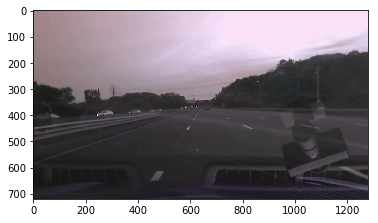

In [2]:
cap = cv2.VideoCapture(processor.get_front_file(1))
ret, frame = cap.read()
cap.release()
plt.imshow(frame)
#shape
print('shape:')
frame.shape

查看转向数据文件

In [3]:
wheel01 = utils.fetch_csv_data(processor.get_steering_file(1))
wheel01.head(10)

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0
5,1464650070452581,5,-1.0
6,1464650070485914,6,-1.0
7,1464650070519247,7,-1.0
8,1464650070552581,8,-1.0
9,1464650070585914,9,-1.5


查看合并数据集

Records in epoch01_steering.csv : 1500
Records in epoch02_steering.csv : 3900
Records in epoch03_steering.csv : 2700
Records in epoch04_steering.csv : 2700
Records in epoch05_steering.csv : 2700
Records in epoch06_steering.csv : 2700
Records in epoch07_steering.csv : 2700
Records in epoch08_steering.csv : 2700
Records in epoch09_steering.csv : 2700
Records in epoch10_steering.csv : 2700
Total records from epoch01 to epoch10 : 27000


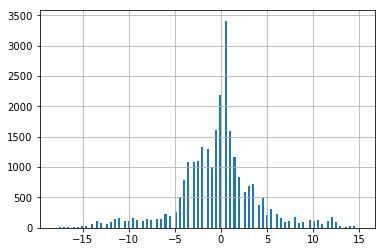

In [4]:
processor.check_dataset(1,10)

读取图片

In [22]:
def show_img(img):
    plt.imshow(img)
    plt.show()

Records in epoch01_steering.csv : 1500
Wheel of frame 1173 : 4.5


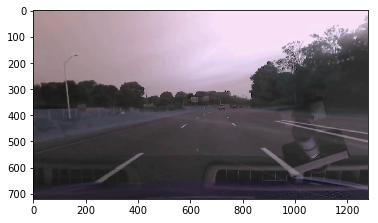

In [5]:

    
# load
sample_img = utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
epoch1 = processor.get_combine_dataset(1,1)
sample_sig = epoch1[1173]
print('Wheel of frame 1173 : '+str(sample_sig))
#show
show_img(sample_img)

改变色域

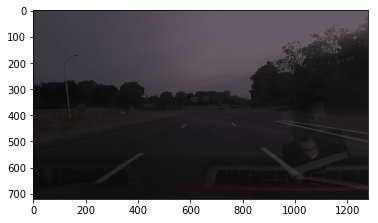

In [33]:
def change_color_space(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img[:, :, 2] = img[:, :, 2] *np.random.uniform(0.1,1)
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
#sample_img=processor.change_color_space(sample_img)
sample_img=change_color_space(sample_img)
show_img(sample_img)

平移图像

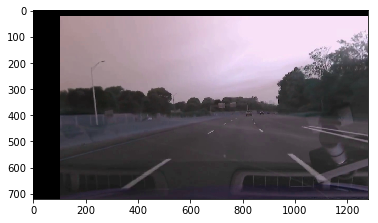

In [62]:
sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=processor.translate(sample_img)
show_img(sample_img)

缩放图像

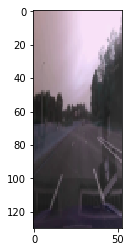

In [63]:
sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=processor.resize(sample_img)
show_img(sample_img)

### Checkpoint 1 is here

In [1]:
import processor
import params
import numpy as np
import modelcoder
import utils

Using TensorFlow backend.


分批读取数据集

In [2]:
all_features,all_labels = processor.load_dataset(need_ori=True)

Start to load datasets...
Processing epoch01>>>
Frames in features01.p : 3000
Records in labels01.p : 3000
Processing epoch02>>>
Frames in features02.p : 7800
Records in labels02.p : 7800
Processing epoch03>>>
Frames in features03.p : 5400
Records in labels03.p : 5400
Processing epoch04>>>
Frames in features04.p : 5400
Records in labels04.p : 5400
Processing epoch05>>>
Frames in features05.p : 5400
Records in labels05.p : 5400
Processing epoch06>>>
Frames in features06.p : 5400
Records in labels06.p : 5400
Processing epoch07>>>
Frames in features07.p : 5400
Records in labels07.p : 5400
Processing epoch08>>>
Frames in features08.p : 5400
Records in labels08.p : 5400
Processing epoch09>>>
Frames in features09.p : 5400
Records in labels09.p : 5400
Done
Length of features : 48600, length of labels : 48600


Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(2400, 64, 64, 3) (2400, 1)
Shape of test set
(600, 64, 64, 3) (600, 1)
Start training
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 3s - loss: 10.7311 - val_loss: 10.9155
Epoch 2/10
1920/1920 [==============================] - 2s - loss: 10.4358 - val_loss: 10.9116
Epoch 3/10
1920/1920 [==============================] - 2s - loss: 10.4403 - val_loss: 10.9126
Epoch 4/10
1920/1920 [==============================] - 2s - loss: 10.4331 - val_loss: 10.9173
Epoch 5/10
1920/1920 [==============================] - 2s - loss: 10.4245 - val_loss: 10.9197
Epoch 6/10
1920/1920 [==============================] - 2s - loss: 10.4169 - val_loss: 10.9325
Epoch 7/10
1920/1920 [==============================] - 2s - loss: 10.4323 - val_loss: 10.9358
Epoch 8/10
1920/1920 [==============================] - 2s - los

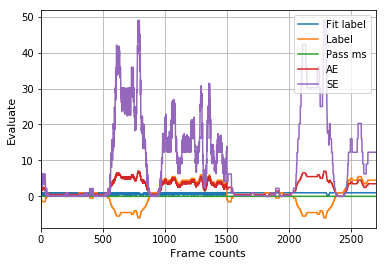

Mean absolute error is 2.564262860799829
Mean squared  error is 10.392369138270519
Mean pass ms is 0.0013897053400675455


In [3]:
model = modelcoder.get_nvidia_model()
fitted_model = processor.fit_model(all_features,all_labels,model,epochs=10)
processor.evaluate_final_model(model,all_features,all_labels)

In [3]:
model = modelcoder.get_nvidia_model_2()
fitted_model = processor.fit_model(all_features,all_labels,model,epochs=10)

Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(38880, 64, 64, 3) (38880, 1)
Shape of test set
(9720, 64, 64, 3) (9720, 1)
Start training
Train on 31104 samples, validate on 7776 samples
Epoch 1/10
31104/31104 [==============================] - 289s - loss: 20.9229 - val_loss: 21.2647
Epoch 2/10
31104/31104 [==============================] - 282s - loss: 19.0444 - val_loss: 22.3491
Epoch 3/10
31104/31104 [==============================] - 282s - loss: 17.4212 - val_loss: 19.5392
Epoch 4/10
31104/31104 [==============================] - 281s - loss: 15.9007 - val_loss: 17.4973
Epoch 5/10
31104/31104 [==============================] - 282s - loss: 15.0472 - val_loss: 15.5542
Epoch 6/10
31104/31104 [==============================] - 280s - loss: 14.3697 - val_loss: 14.2285
Epoch 7/10
31104/31104 [==============================] - 280s - loss: 13.8697 - val_loss: 14.0403
Epoch 8/10
31104/31104 [======

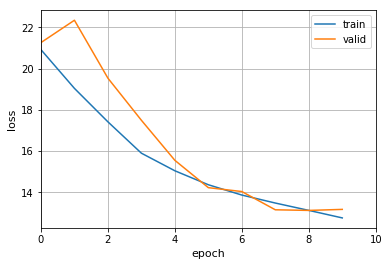

In [4]:

processor.display_fit_result(fitted_model)

In [5]:
processor.save_model(model)

Model and weights already saved


In [6]:
import run

Model already exists, do you want to reuse? (y/n): y
Model fetched from the disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 24)        672       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 24)        96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        6944      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_____________________________________________________________

### Checkpoint 2 is here

Frames in features10.p : 2700
Records in labels10.p : 2700
Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(38880, 64, 64, 3) (38880, 1)
Shape of test set
(9720, 64, 64, 3) (9720, 1)
Start training
Train on 31104 samples, validate on 7776 samples
Epoch 1/10
31104/31104 [==============================] - 291s - loss: 20.7270 - val_loss: 21.1054
Epoch 2/10
31104/31104 [==============================] - 288s - loss: 19.0055 - val_loss: 20.5717
Epoch 3/10
31104/31104 [==============================] - 287s - loss: 17.3719 - val_loss: 19.6740
Epoch 4/10
31104/31104 [==============================] - 293s - loss: 15.8757 - val_loss: 17.3597
Epoch 5/10
31104/31104 [==============================] - 288s - loss: 14.7255 - val_loss: 15.1893
Epoch 6/10
31104/31104 [==============================] - 285s - loss: 14.0463 - val_loss: 14.0131
Epoch 7/10
31104/31104 [==============================] - 284s - loss:

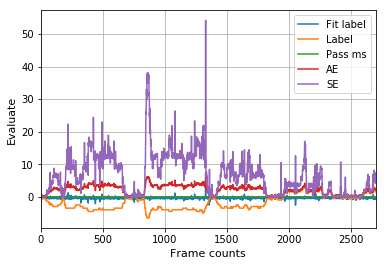

Mean absolute error is 2.1612604904906068
Mean squared  error is 6.488779760496432
Mean pass ms is 0.005157252682579889


In [7]:
import utils
import cv2
import params
import matplotlib.pyplot as plt
import time
import processor
import numpy as np
import modelcoder

features_file = utils.join_dir(params.pickle_dir,'features10.p')
labels_file = utils.join_dir(params.pickle_dir,'labels10.p')

features = processor.load_features(features_file,10)
labels = processor.load_labels(labels_file,10)

model = modelcoder.get_nvidia_model_2()
fitted_model=processor.fit_model(all_features,all_labels,model,epochs=10)
processor.evaluate_final_model(model,features,labels)


Records in labels10.p : 2700
Start to evaluate model
Completed,output result...


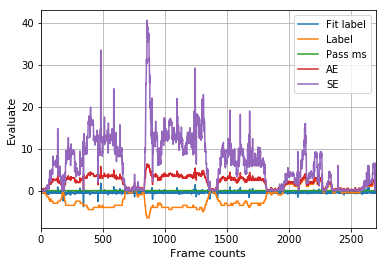

Mean absolute error is 2.1597914642564677
Mean squared  error is 6.49805247187552
Mean pass ms is 0.00510205798678928


In [9]:
def get_combine_img(need_ori=False):
    video_idx = 10
    imgs = []
    tims_idx = [499,999,1499,1999,2499]
    f = 0
    cap = cv2.VideoCapture(utils.join_dir(params.data_dir,'epoch{:0>2}_front.mkv'.format(video_idx)))

    while True:
        ret, frame = cap.read()
        if not ret:
            break;
        #pre-process
        if f in tims_idx:
            frame = img_pre_process_times(frame,2)
        else:
            frame = processor.img_pre_process(frame,need_ori)
        imgs.append(frame)
        f = f+1
    cap.release()
    return imgs

def img_pre_process_times(img,times):
    for i in range(1,times+1):
        img = processor.change_color_space(img)
        img = processor.translate(img)
        img = processor.resize(img)
    return np.resize(img, (params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c))
        
features = get_combine_img()
labels = processor.load_labels(labels_file,10)

processor.evaluate_final_model(model,features,labels)

Frames in features10.p : 2700
Records in labels10.p : 2700
Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(38880, 64, 64, 3) (38880, 1)
Shape of test set
(9720, 64, 64, 3) (9720, 1)
Start training
Train on 31104 samples, validate on 7776 samples
Epoch 1/10
31104/31104 [==============================] - 46s - loss: 20.7338 - val_loss: 20.8790
Epoch 2/10
31104/31104 [==============================] - 45s - loss: 20.3121 - val_loss: 20.4377
Epoch 3/10
31104/31104 [==============================] - 45s - loss: 20.0527 - val_loss: 20.4851
Epoch 4/10
31104/31104 [==============================] - 47s - loss: 19.9680 - val_loss: 20.0785
Epoch 5/10
31104/31104 [==============================] - 46s - loss: 19.9677 - val_loss: 20.8775
Epoch 6/10
31104/31104 [==============================] - 45s - loss: 19.8139 - val_loss: 20.0783
Epoch 7/10
31104/31104 [==============================] - 45s - loss: 19.685

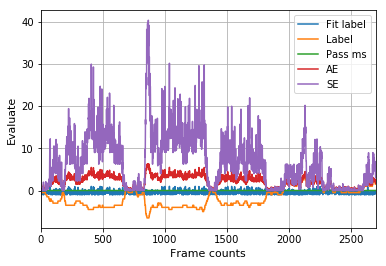

Mean absolute error is 2.180037144397437
Mean squared  error is 6.574834531377734
Mean pass ms is 0.0017440501848856608


In [10]:


features_file = utils.join_dir(params.pickle_dir,'features10.p')
labels_file = utils.join_dir(params.pickle_dir,'labels10.p')

features = processor.load_features(features_file,10)
labels = processor.load_labels(labels_file,10)

model = modelcoder.get_nvidia_model()
fitted_model = processor.fit_model(all_features,all_labels,model,epochs=10)

processor.evaluate_final_model(model,features,labels)